/TL/epigenetics2/work/pebert/conda/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Status plot created


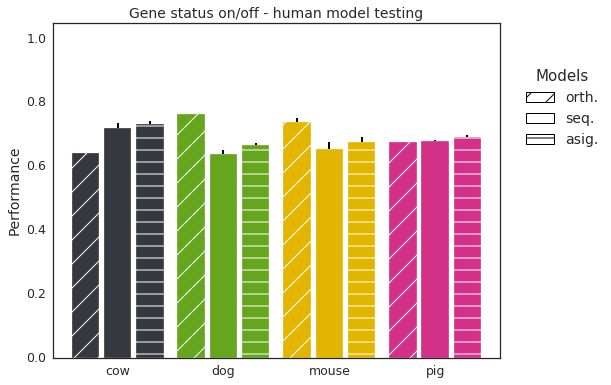

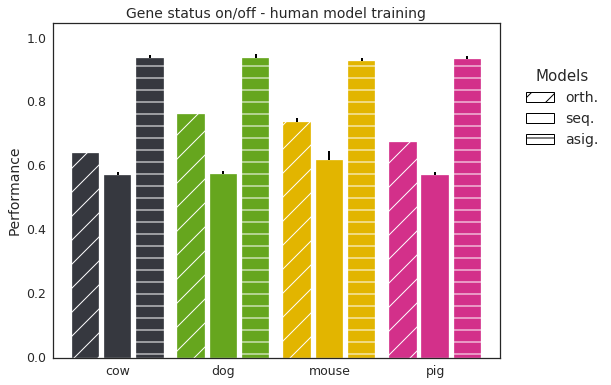

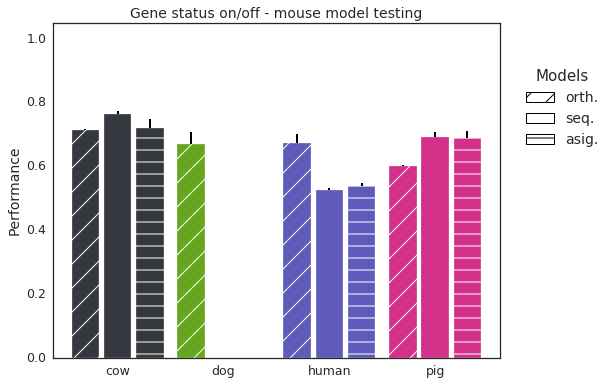

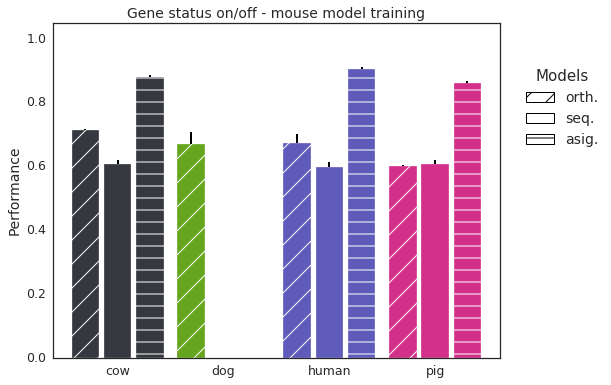

In [3]:
%matplotlib inline

import os as os
import numpy as np
import json as js
import collections as col
import functools as fnt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

from sklearn.metrics import accuracy_score as acc

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['Arial', 'sans-serif']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis'
stat_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_summarize')
orth_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_ortho_pred')
ortho_pred = os.path.join(orth_folder, '5spec_orthodb_ortho-pred.h5')

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))

exec_status = True

show_figures = True
use_hatched_bars = True
ortho_subset = '/tpm/strict'

out_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics/figures'
save_figures = True

def exec_status():
    if not exec_status:
        return False
    for statf in os.listdir(stat_folder):
        assm = statf.split('_')[0]
        species = plot_colors['mapping'][assm]['species']
        bar_labels = {0: 'orth.', 1: 'seq.', 2: 'asig.'}
        if use_hatched_bars:
            hatches = {0: '/', 1: '', 2: '-'}
        else:
            hatches = {0: '', 1: '', 2: ''}
        orth_perf = get_orthopred_perf(species, ortho_subset, ortho_perf_status)
        test_perf = get_model_perf(os.path.join(stat_folder, statf), assm, 'roc_auc', 'testing')
        performances = {0: orth_perf, 1: test_perf['seq'], 2: test_perf['asig']}
        plot_title = 'Gene status on/off - {} model testing'.format(species)
        fig, exart = plot_perf_barchart(performances, plot_title, bar_labels, hatches, use_hatched_bars)
        if save_figures:
            outpath = os.path.join(out_folder, 'main', 'fig_X_main_{}_gstat_test_perf.svg'.format(species))
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
        train_perf = get_model_perf(os.path.join(stat_folder, statf), assm, 'roc_auc', 'training')
        performances = {0: orth_perf, 1: train_perf['seq'], 2: train_perf['asig']}
        plot_title = 'Gene status on/off - {} model training'.format(species)
        fig, exart = plot_perf_barchart(performances, plot_title, bar_labels, hatches, use_hatched_bars)
        if save_figures:
            outpath = os.path.join(out_folder, 'supp', 'fig_X_supp_{}_gstat_train_perf.svg'.format(species))
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
    return True


def plot_perf_barchart(performances, title, barlabels, hatchstyle, use_hatch):
    """ """
    # number of models/predictions = number of bars per group
    num_preds = len(performances.keys())
    # number of species pairings = number of groups
    num_pairs = len(performances[0].keys())
    first_xloc = 0.2
    bar_width = 0.3
    coords = get_xlocs(first_xloc, bar_width, num_pairs, num_preds)
    
    group_labels = []
    bar_labels = []
    bar_colors = col.defaultdict(list)
    bar_heights = col.defaultdict(list)
    bar_stds = col.defaultdict(list)
    leg_spec = set()
    for gidx, pair in enumerate(sorted(performances[0].keys())):
        group_labels.append(pair[1])
        leg_spec.add((pair[1], tuple(plot_colors['species'][pair[1]]['rgb'])))
        for bidx in sorted(performances.keys()):
            bar_colors[bidx].append(plot_colors['species'][pair[1]]['rgb'])
            pred = performances[bidx]
            if pair not in pred:
                p1 = plot_colors['mapping'][pair[0]]['assembly']
                p2 = plot_colors['mapping'][pair[1]]['assembly']
                access = p1, p2
            else:
                access = pair
            if access == ('mm9', 'canFam3'):
                bar_heights[bidx].append(0)
                bar_stds[bidx].append(0)
                bar_labels.append('n/a')
            else:
                ht = np.mean(pred[access])
                assert not np.isnan(ht), 'Invalid mean for pair {}: {}'.format(pair, pred)
                std = np.std(pred[access])
                assert not np.isnan(std), 'Invalid std for pair {}: {}'.format(pair, pred)
                bar_heights[bidx].append(ht)
                bar_stds[bidx].append(std)
                bar_labels.append(barlabels[bidx])
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlim(0, coords['x_end'])
    ax.set_ylim(0, 1.05)
    bar_rects = []
    neg_stds = np.zeros(len(bar_stds[0]))
    for idx in sorted(bar_colors.keys()):
        rects = ax.bar(coords['bar_xlocs'][idx], bar_heights[idx], bar_width,
                       color=bar_colors[idx], yerr=[neg_stds, bar_stds[idx]],
                       hatch=hatchstyle[idx], edgecolor='white',
                       error_kw=dict(ecolor='black', capsize=7, capthick=0,
                                     lw=2))
        bar_rects.append(rects)
    extra_artists = []
    if use_hatch:
        # legend for model
        model_handles = []
        for hid in sorted(hatchstyle.keys()):
            pat = hatchstyle[hid]
            modlab = barlabels[hid]
            model_handles.append(mpatches.Patch(facecolor='white', label=modlab,
                                                hatch=pat, edgecolor='black',
                                                ls='solid', lw=1))
        leg_models = plt.legend(handles=model_handles, loc=1, title='Models',
                                markerscale=1.5, fontsize=14, bbox_to_anchor=(1.25, 0.9))
        extra_artists.append(leg_models)
        group_ticks = coords['group_mids']
        ax.set_xticks(group_ticks)
        ax.set_xticklabels(group_labels)
        
    else:
        # legend for species
        species_handles = []
        for entry in sorted(leg_spec):
            species_handles.append(mpatches.Patch(color=entry[1], label=entry[0]))

        leg_spec = plt.legend(handles=species_handles, loc=1, title='Species',
                              markerscale=1.5, fontsize=14, bbox_to_anchor=(1.25, 0.9))
        extra_artists.append(leg_spec)
        
        bar_xticks = []
        for mids in coords['bar_mids'].values():
            bar_xticks.extend(mids)
        ax.set_xticks(sorted(bar_xticks))
        ax.set_xticklabels(bar_labels)

    ax.set_ylabel('Performance', fontsize=14)
    ax.set_title(title, fontsize=14)
    return fig, extra_artists

    
def get_xlocs(start_value, bar_width, num_groups, group_bars):
    """ """
    bar_space = 0.05
    group_skip = 0.15
    bar_xlocs, bar_mids = col.defaultdict(list), col.defaultdict(list)
    last_xloc = start_value
    group_coords = col.defaultdict(dict)
    for gidx in range(num_groups):
        if gidx == 0:
            group_coords[0]['start'] = last_xloc
        else:
            group_coords[gidx - 1]['end'] = last_xloc
            last_xloc += group_skip
            group_coords[gidx]['start'] = last_xloc
        for bidx in range(group_bars):
            bar_xlocs[bidx].append(last_xloc)
            bar_mid = last_xloc + bar_width / 2.
            bar_mids[bidx].append(bar_mid)
            last_xloc += bar_width
            last_xloc += bar_space
        last_xloc -= bar_space
    group_coords[num_groups - 1]['end'] = last_xloc
    group_mids = []
    for g in sorted(group_coords.keys()):
        s, e = group_coords[g]['start'], group_coords[g]['end']
        group_mids.append(s + (e - s) / 2.)
    result = {'bar_xlocs': bar_xlocs, 'bar_mids': bar_mids,
              'group_mids': group_mids, 'x_end': last_xloc + start_value}
    return result

        
def get_model_perf(fp, assm, scoring, setting):
    seq_perf = col.defaultdict(list)
    asig_perf = col.defaultdict(list)
    df = pd.read_csv(fp, delimiter='\t', header=0)
    gen_idx = np.logical_and(df['target'] == assm, df['scoring'] == scoring)
    idx = np.logical_and(df['setting'] == setting, gen_idx)
    df = df.loc[idx,:]
    for qry in df['query'].unique():
        seqm_idx = df['model_file'].str.contains('.seq.')
        qry_idx = df['query'] == qry
        idx = np.logical_and(seqm_idx, qry_idx)
        sub = df.loc[idx, :]
        seq_perf[(assm, qry)].extend(sub['score'].tolist())
        
        asigm_idx = df['model_file'].str.contains('.asig.')
        idx = np.logical_and(asigm_idx, qry_idx)
        sub = df.loc[idx, :]
        asig_perf[(assm, qry)].extend(sub['score'].tolist())
    result = {'seq': seq_perf, 'asig': asig_perf}
    return result
        
        
        
def ortho_perf_status(collector):
    perfs = col.defaultdict(list)
    for k, vals in collector.items():
        st = k[0].split('_')[0]
        sq = k[1].split('_')[0]
        wt_zero = 0.5 / sum([1 if v[1] < 1 else 0 for v in vals])
        wt_one = 0.5 / sum([1 if v[1] >= 1 else 0 for v in vals])
        pred_label = [1 if v[0] >= 1 else 0 for v in vals]
        true_label = [1 if v[1] >= 1 else 0 for v in vals]
        wt_vec = [wt_one if l == 1 else wt_zero for l in true_label]
        perf = acc(true_label, pred_label, sample_weight=wt_vec)
        perfs[(st, sq)].append(perf)
    return perfs      
                    
        
def get_cell_pairings(targets, queries):
    use_pairs = []
    for t in targets:
        for q in queries:
            tl = plot_labels[t]
            ql = plot_labels[q]
            if tl == ql:
                use_pairs.append((t, q, tl))
    return use_pairs
 
    
def process_row(collector, row):
    for k in collector.keys():
        tval = getattr(row, k[0])
        qval = getattr(row, k[1])
        collector[k].append((tval, qval))
    return        
    
    
def get_ortho_mapping(samples, reference):
    species = set()
    av_cells = col.defaultdict(list)
    for s in samples:
        spec, cell = s.split('_')
        species.add(spec)
        av_cells[spec].append(cell)
    collector = dict()
    species.remove(reference)
    ref_cells = av_cells[reference]
    for s in species:
        cell_pairs = get_cell_pairings(ref_cells, av_cells[s])
        for item in cell_pairs:
            collector[(reference + '_' + item[0], s + '_' + item[1])] = list()
    return collector
    
        
        
def get_orthopred_perf(species, subset, pfun):
    with pd.HDFStore(ortho_pred, 'r') as hdf:
        dataset = hdf[subset]
    dataset = dataset.transpose()
    sample_types = []
    for item in dataset.index:
        _, sample = item.split('_', 1)
        sample_types.append(sample)
    dataset['sample'] = sample_types
    dataset = dataset.groupby('sample').mean()
    dataset = dataset.transpose()
    collector = get_ortho_mapping(dataset.columns, species)
    proc_row = fnt.partial(process_row, *(collector,))
    for row in dataset.itertuples():
        proc_row(row)
    res = pfun(collector)
    return res
        
    
    
    
    
execd = exec_status()
if execd:
    print('Status plot created')
    
execd = exec_rank()
